# This notebook is calculate accuaracy of CIFAR 10 quick with NVDLA

## Environment

* NVDLA 
    * Hardware: nvdla/nvdlav1
    * Software: nvdla/sw @github 06/01/2018
* Model
    * Dataset: 10000 images of CIFAR10 test  
    * Model: CIFAR 10 quick

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import caffe
import time
import glob

In [2]:
def top_k(result, top_num, label_arr):
    tmp = -(top_num+1)
    top_k = result.flatten().argsort()[-1:tmp:-1]
    top_num = 1
    for i in np.arange(top_k.size):
        print("Top %d:\tProb:%2.4f%%\t[%d]\t %s"%(top_num,result[top_k[i]]*100,top_k[i], labels[top_k[i]]))
        top_num = top_num + 1

In [3]:
def read_files(path,fileType):
    dimg_files = []
    for root, directories, filenames in os.walk(path):
        for filename in filenames:
            if fileType in filename:
                dimg_files.append(os.path.join(root,filename))
    return dimg_files

In [4]:
def read_dimg(dimg_file):
    return np.genfromtxt(dimg_file, float, delimiter=' ')

In [5]:
def caffe_inference(image_path, model_def, weight, w, h):
    
    # Configure
    pycaffe_dir = '/home/caslab/workspace/caffe/caffe/python/'
    model_dir = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/model/yolo'
    input_file = image_path
    model_def = os.path.join(model_dir,model_def)
    pretrained_model = os.path.join(model_dir, weight)
    gpu = False
    center_only = True
    images_dim = str(w)+','+str(h)
    mean_file = None
    # input_scale = 
    raw_scale = 255.0
    channel_swap = '2,1,0'
    ext = 'jpg'
    image_dims = [int(s) for s in images_dim.split(',')]
    mean, channel_swap_arr = None, None
    
    # Setup parameter
    if mean_file:
        mean = np.load(mean_file)
    if channel_swap:
        channel_swap_arr = [int(s) for s in channel_swap.split(',')]
    if gpu:
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()

    # Create classifier class
    classifier = caffe.Classifier(model_def, pretrained_model,
            image_dims=image_dims, mean=mean,
            raw_scale=raw_scale,
            channel_swap=channel_swap_arr)
    
    # Load image file.
    inputs =[caffe.io.load_image(input_file)]

    # Classify
    predictions = classifier.predict(inputs, not center_only)
    
    return predictions[0]

In [6]:
dimg_root_path = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/runtime/test/'
dimg_files = read_files(dimg_root_path,'dimg')
image_root = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/image/test_cifar/'
prototxt_path = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/model/cifar_quick/prototxt/cifar10_quick_12_prob.prototxt'  
weight_path = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/model/cifar_quick/weight/cifar10_quick_iter_4000.caffemodel'

test_name = []
nvdla_result = []
caffe_result = []

for element in dimg_files:
    tmp = os.path.basename(element).split('.')[0].split('_')[1]
    image_path = image_root + os.path.basename(element).split('.')[0] + ".jpg"
    test_name.append(tmp)
    nvdla_result.append(read_dimg(element))
    caffe_result.append(caffe_inference(image_path,prototxt_path,weight_path,32,32))


In [7]:
cifar10_synset_file = '/home/caslab/workspace/dataset/cifar/labels.txt'
cifar_labels = np.genfromtxt(cifar10_synset_file, str, delimiter='\n')
label = ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")

In [8]:
show = False
if show:
    for i in range(0,len(nvdla_result)):
        plt.rcdefaults()
        fig, ax = plt.subplots()
        
        y_pos = np.arange(len(label))

        ax.barh(y_pos, nvdla_result[i], align='center',
                color='gray', ecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(label)
        plt.xlabel("Class")
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Probability')
        ax.set_title('CIFAR10 Quick Classification Ans:%s'%test_name[i])

        plt.show()

In [9]:
counter = 0.0
for i in range(0,len(nvdla_result)):
    if (cifar_labels[nvdla_result[i].argmax()] == test_name[i]):
        counter += 1

In [10]:
print("Accuracy: %.3f%%, Totol test num: %d"%((counter*100/len(nvdla_result)),len(nvdla_result)))

Accuracy: 24.830%, Totol test num: 10000


In [11]:
counter = 0.0
for i in range(0,len(caffe_result)):
    if (cifar_labels[caffe_result[i].argmax()] == test_name[i]):
        counter += 1

In [12]:
print("Accuracy: %.3f%%, Totol test num: %d"%((counter*100/len(caffe_result)),len(caffe_result)))

Accuracy: 24.300%, Totol test num: 10000


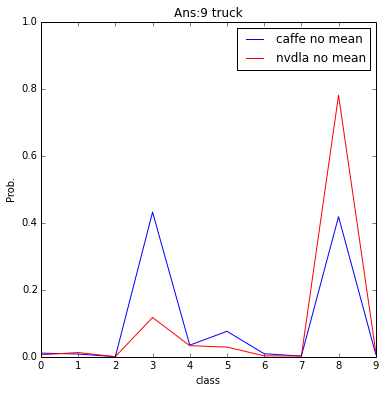

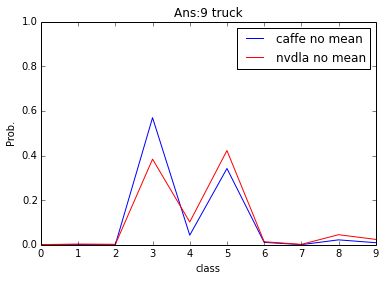

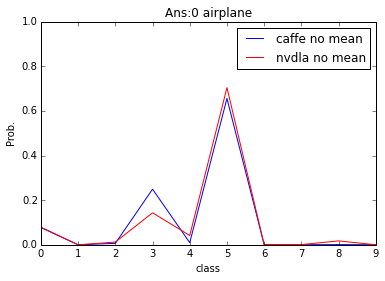

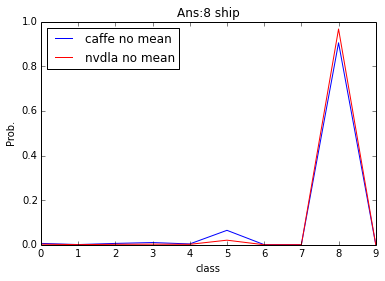

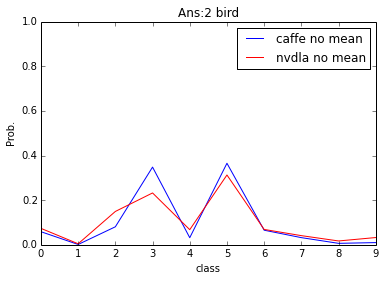

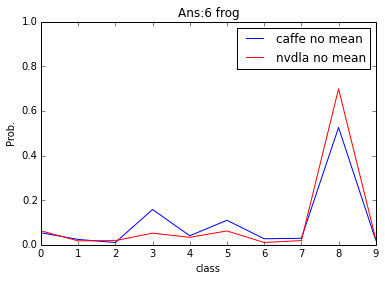

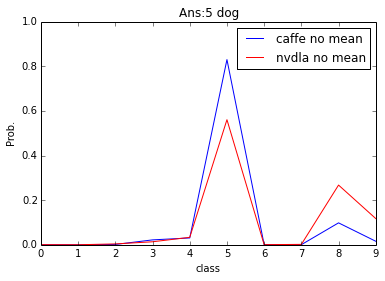

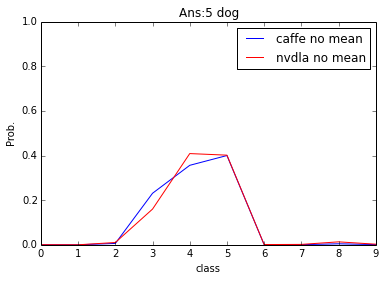

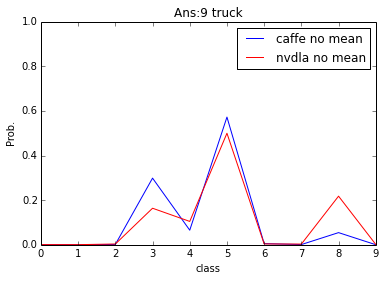

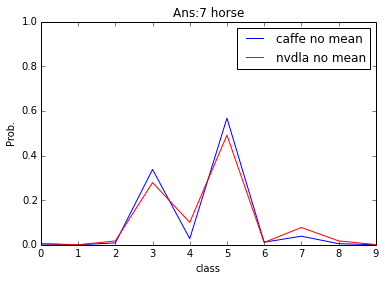

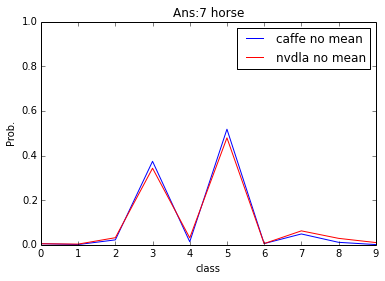

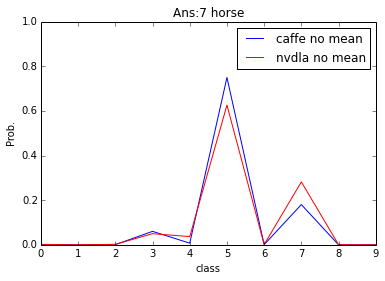

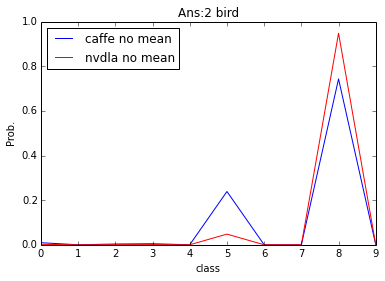

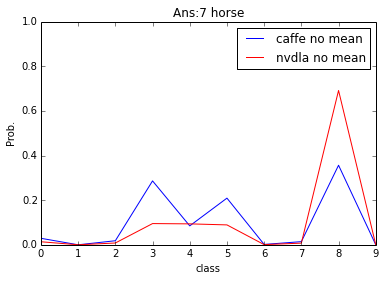

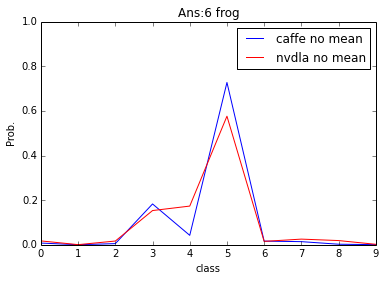

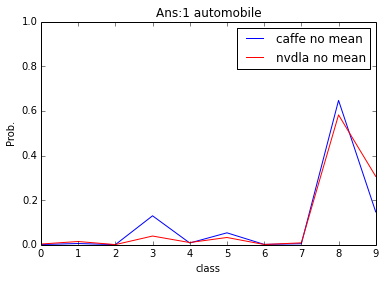

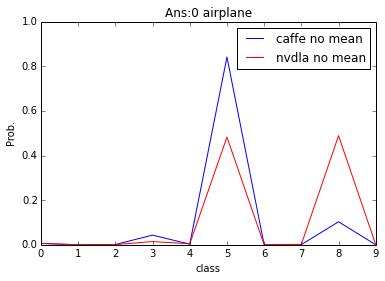

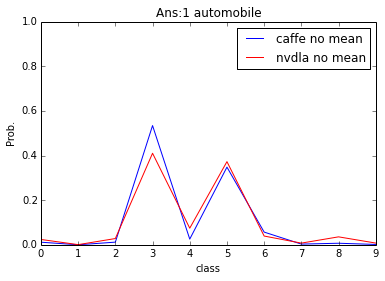

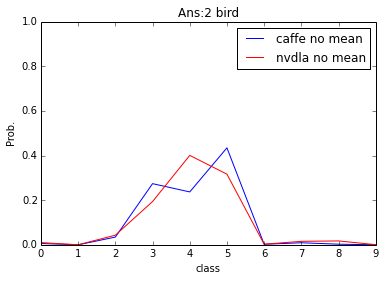

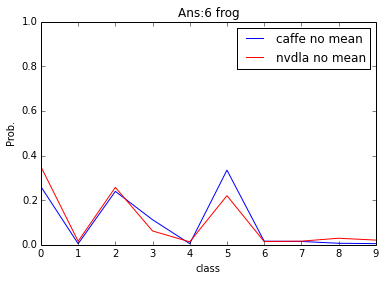

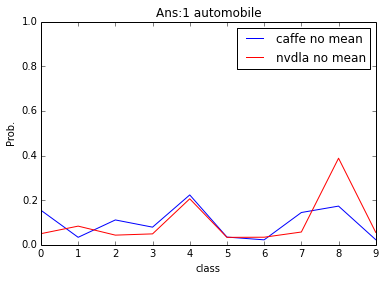

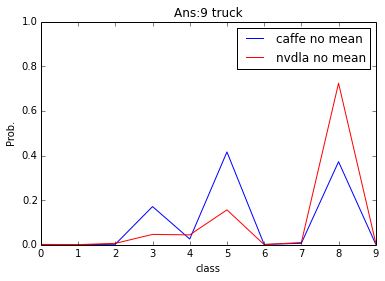

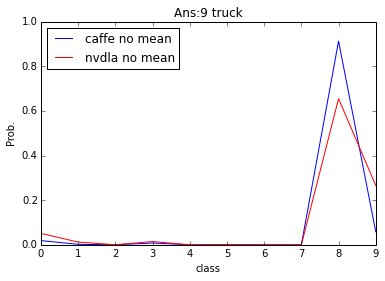

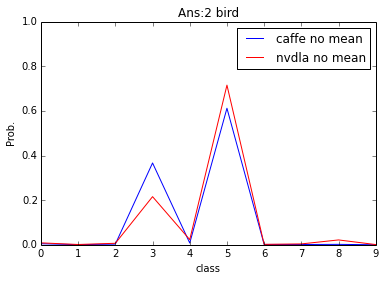

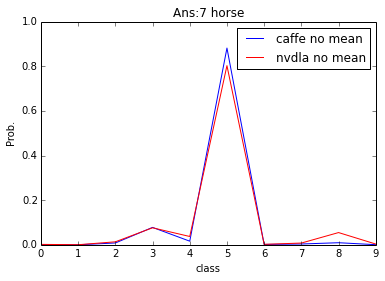

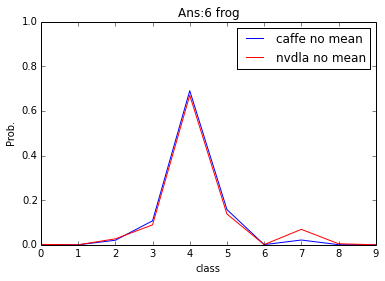

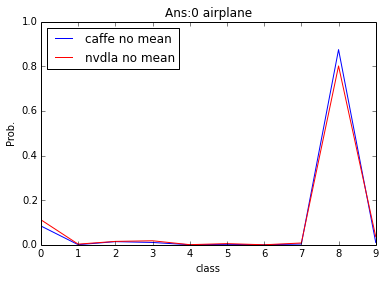

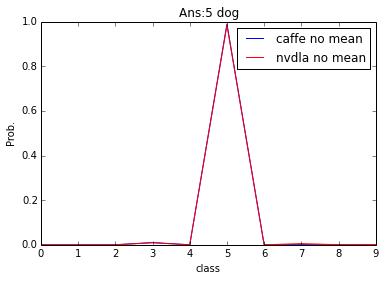

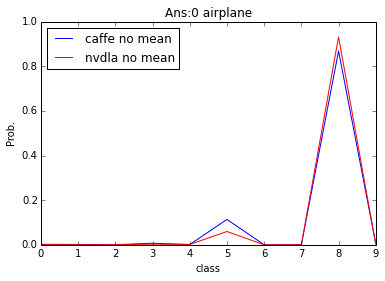

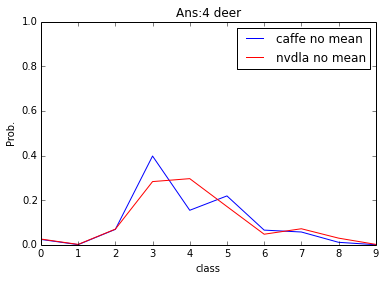

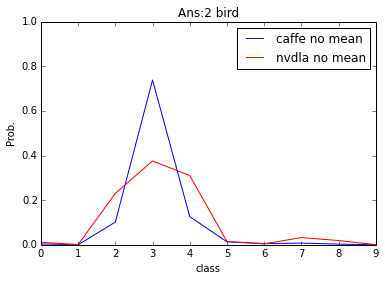

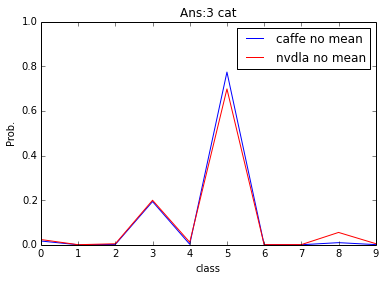

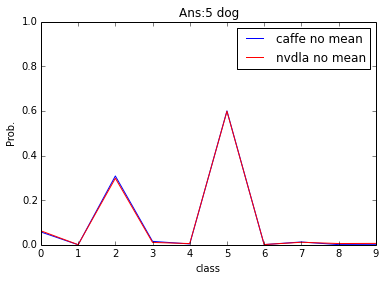

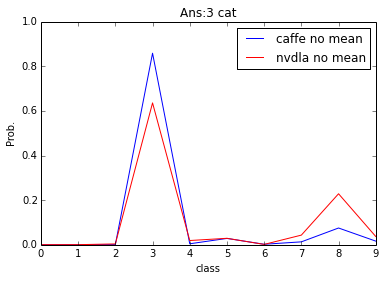

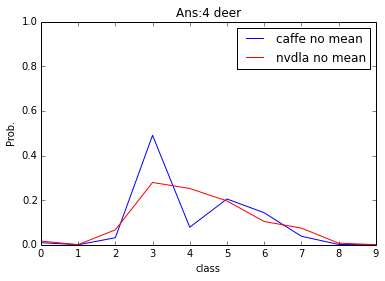

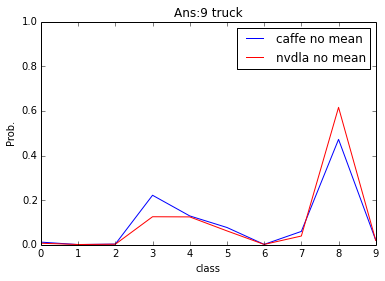

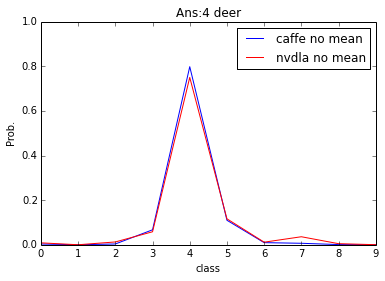

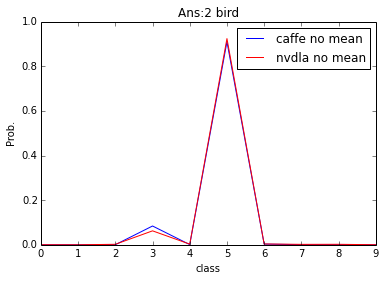

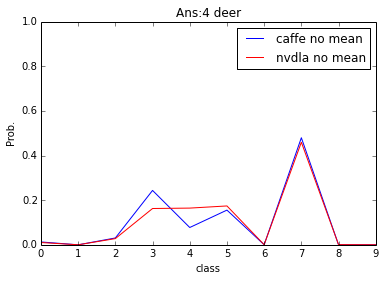

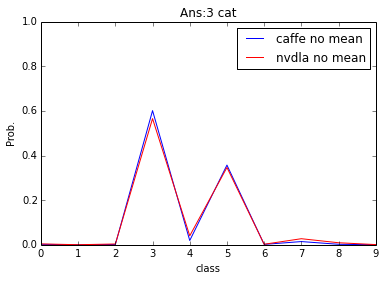

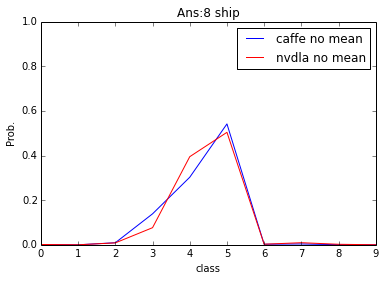

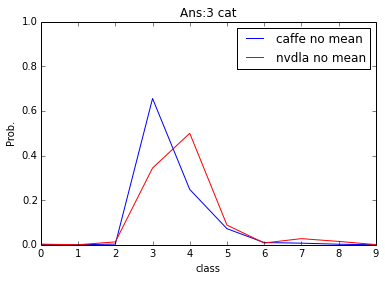

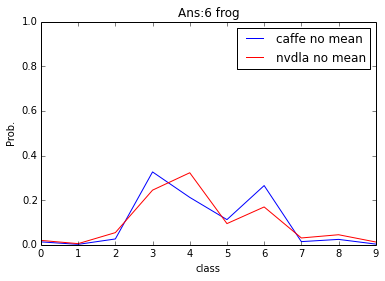

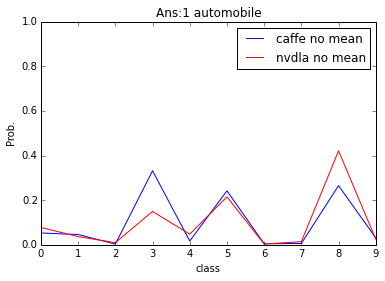

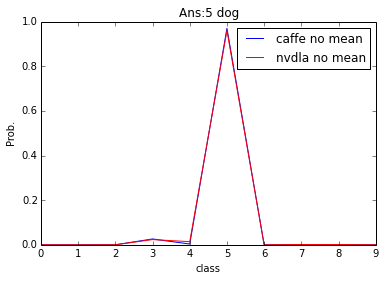

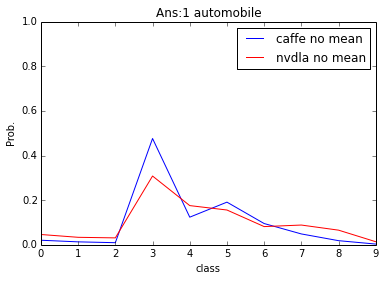

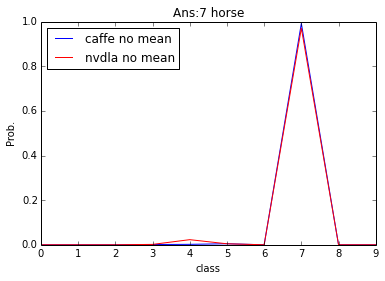

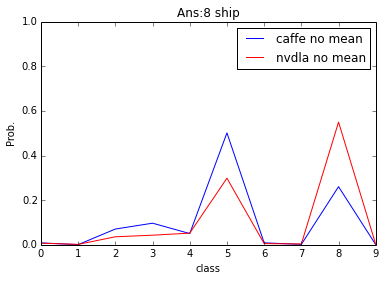

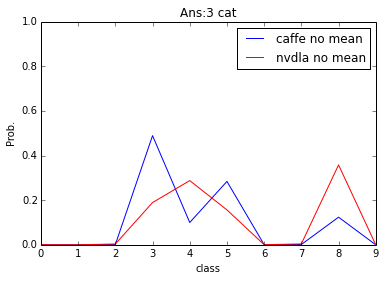

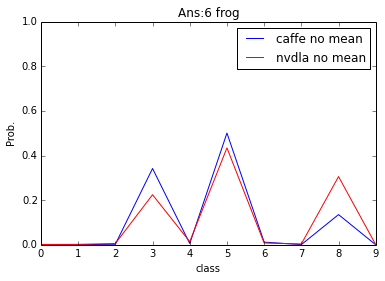

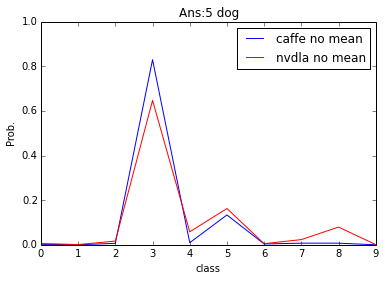

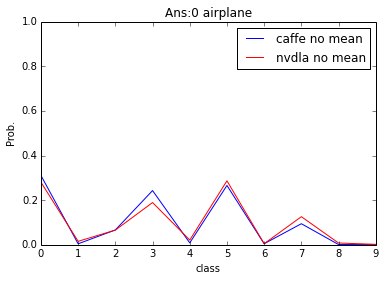

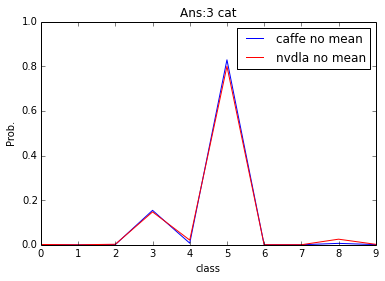

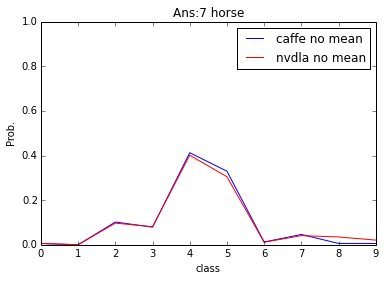

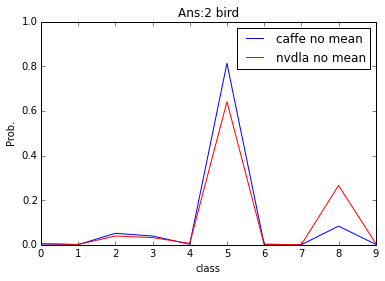

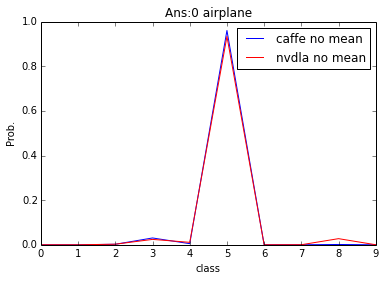

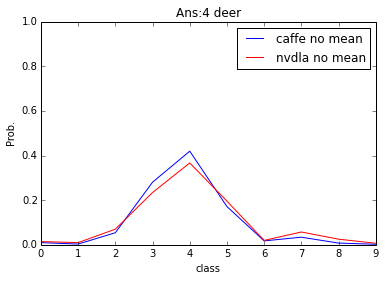

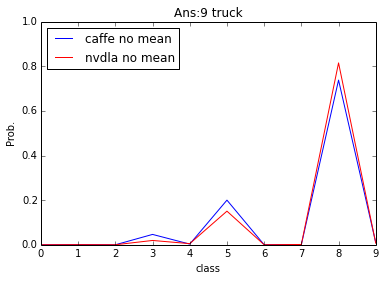

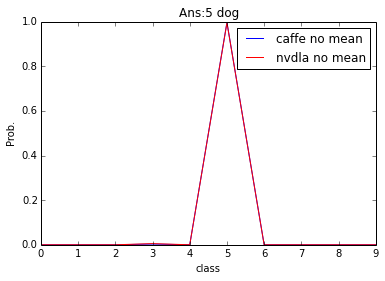

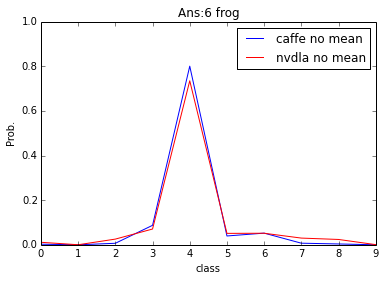

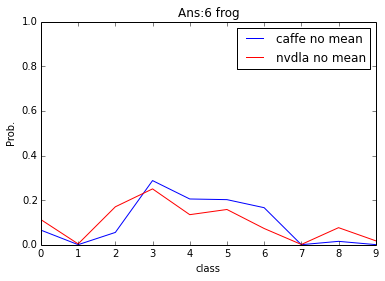

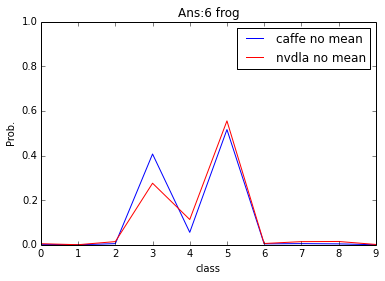

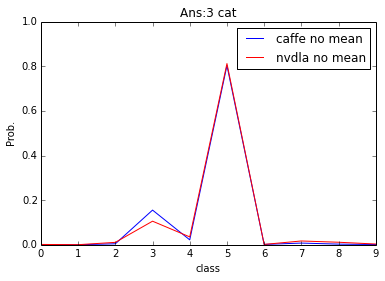

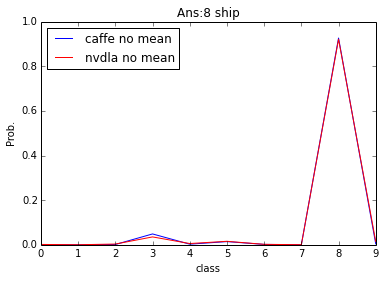

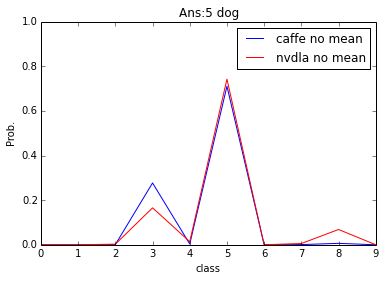

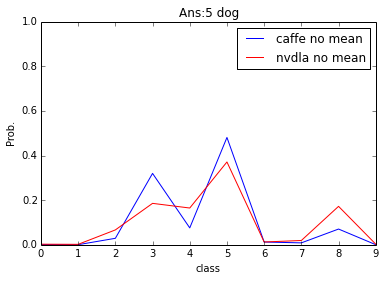

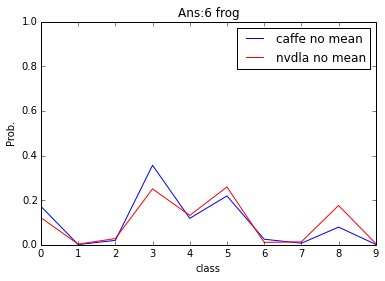

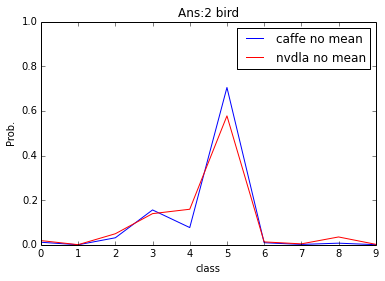

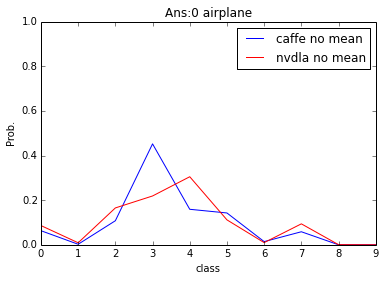

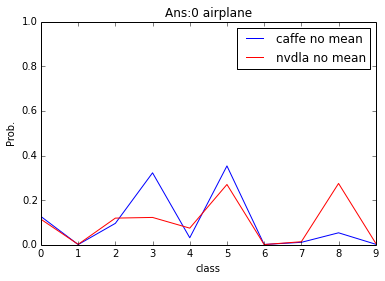

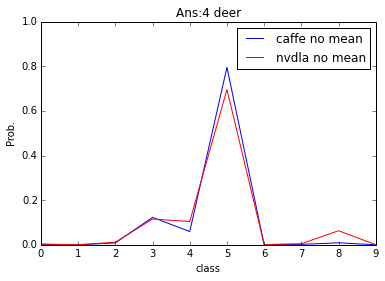

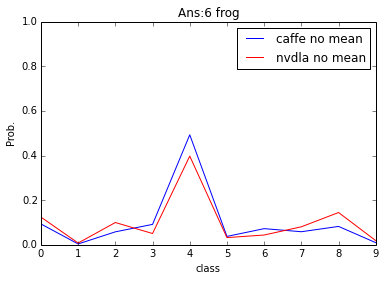

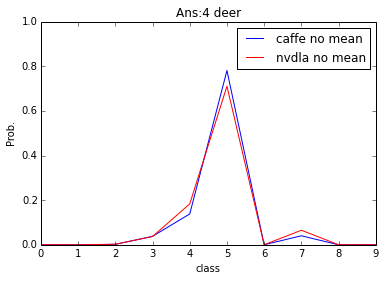

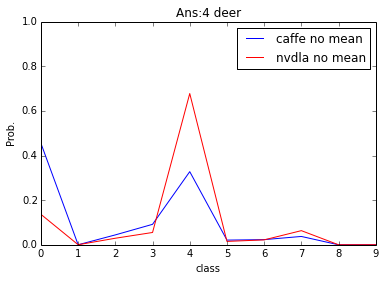

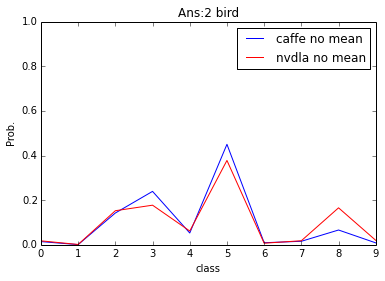

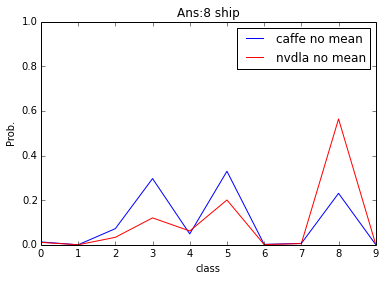

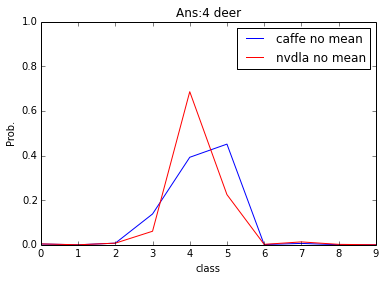

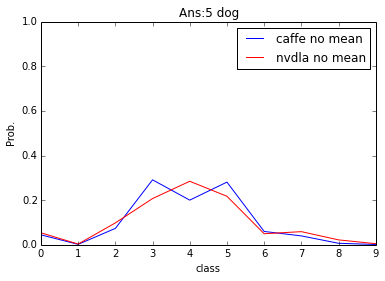

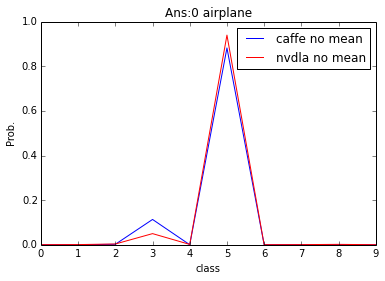

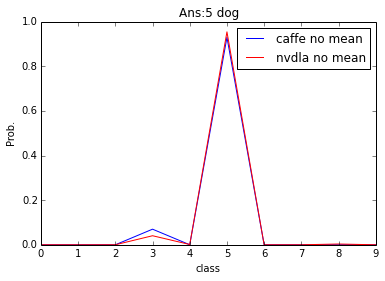

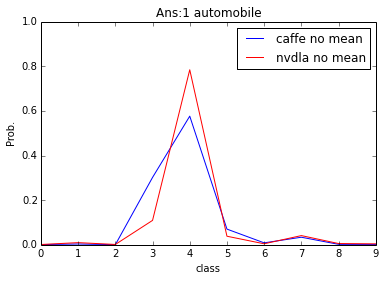

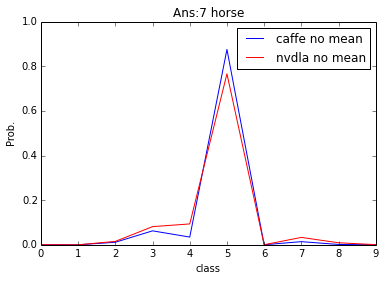

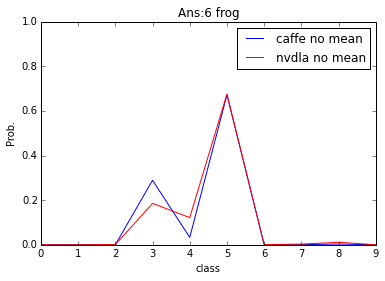

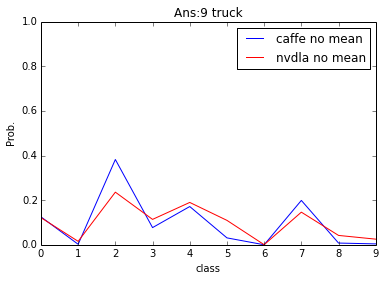

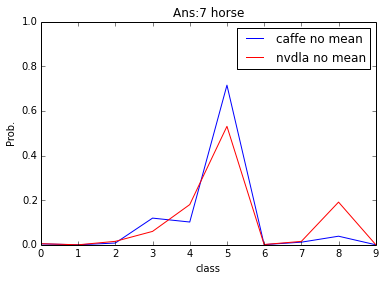

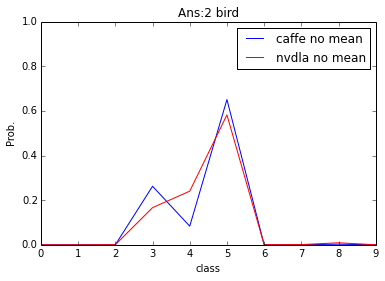

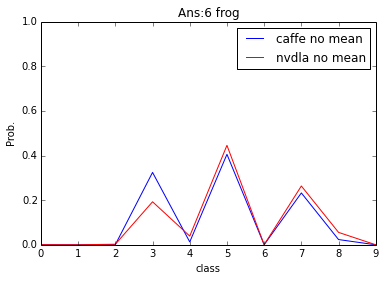

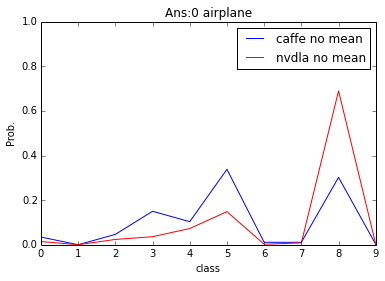

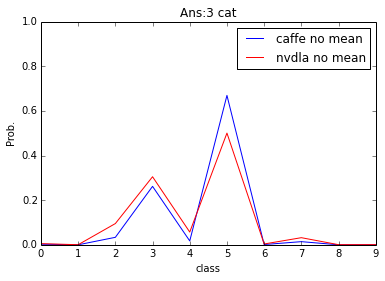

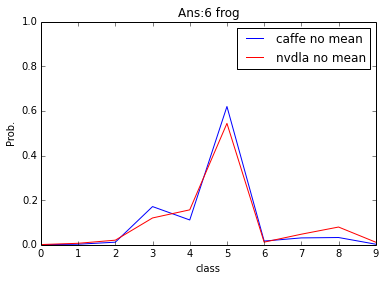

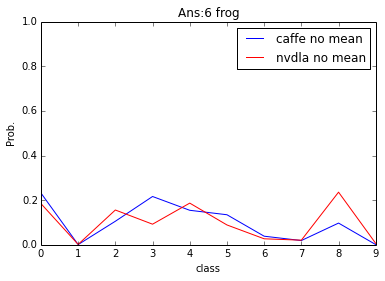

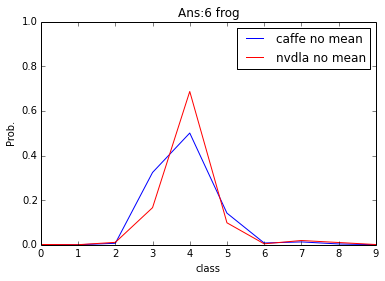

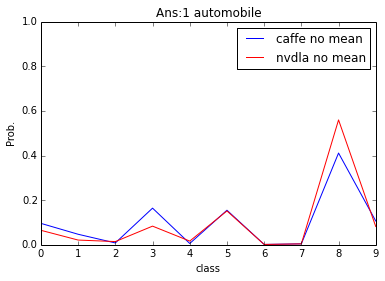

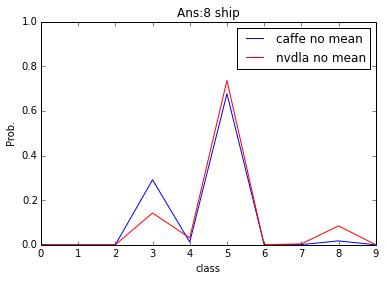

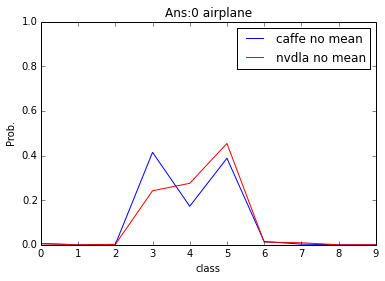

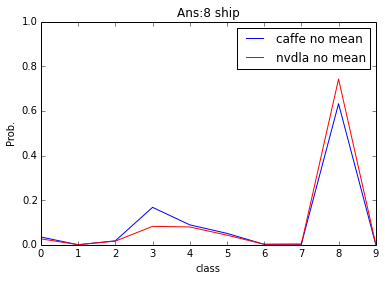

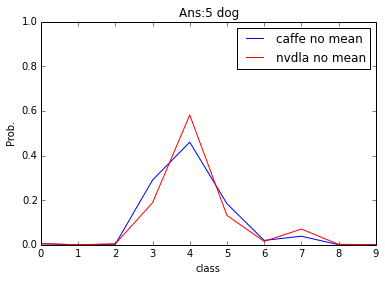

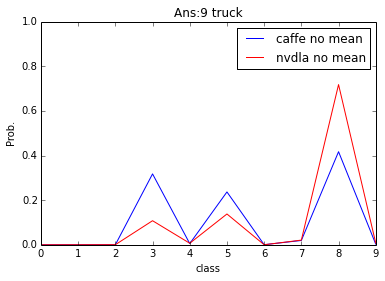

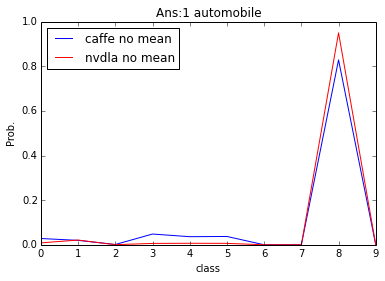

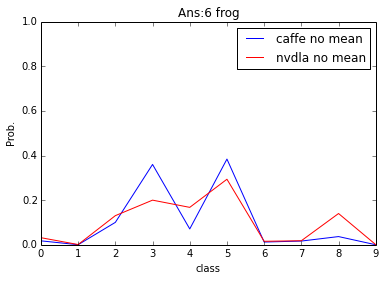

In [13]:
pixel_width = 6
pixel_height = 6
plt.figure(figsize=(pixel_width, pixel_height))
aa = range(0,10)
for z in range(0,100):
    l1, = plt.plot(aa,caffe_result[z], 'b-' , label = 'caffe no mean')
    l2, = plt.plot(aa,nvdla_result[z], 'r-' , label = 'nvdla no mean')


    plt.xlim((0, 9))
    plt.ylim((0, 1))
    plt.title("Ans:%d %s"%(label.index( test_name[z]),test_name[z]))
    plt.xlabel('class')
    plt.ylabel('Prob.')
    
#     plt.legend(handles = [l1, l2,], labels = ['caffe', 'nvdla'], loc = 'best')
    plt.legend(loc = 'best') #, labels = ['caffe', 'no mean'], loc = 'best')

    plt.show()
#     print("-----------loss rate: %2.3f%% | cross entropy: %f -----------------"%((caffe_nvdla_loss[z]*100),(caffe_nvdla_cross_entropy[z])))
# 
# # print aa
# plt.plot(aa,predictions[0],'y--',aa, dimg_no_mean , 'r--', aa, dimg_mean_bgr, 'b--', aa, dimg_mean_rgb, 'g--')
# plt.axis([0, 50, 0, 1])
# plt.show()